In [237]:
import datetime
from datetime import timedelta
import os
import wget
import pandas as pd
import urllib.request

today = datetime.date.today()
yesterday = today - timedelta(days = 1)

In [238]:
daysinmonth = int(str(today)[-2:])
if daysinmonth < 7:
    daysinweek = daysinmonth
else:
    daysinweek = 7
    
print(daysinmonth)
print(daysinweek)

12
7


In [239]:
#create list that contains 7 days since today
week = []
for i in range(daysinweek):
    week.append(today - timedelta(days = i))
    week[i] = str(week[i])

print(week)

#create list that contains 30 days since today
month = []
for i in range(daysinmonth):
    month.append(today - timedelta(days = i))
    month[i] = str(month[i])

print(month)

['2021-10-12', '2021-10-11', '2021-10-10', '2021-10-09', '2021-10-08', '2021-10-07', '2021-10-06']
['2021-10-12', '2021-10-11', '2021-10-10', '2021-10-09', '2021-10-08', '2021-10-07', '2021-10-06', '2021-10-05', '2021-10-04', '2021-10-03', '2021-10-02', '2021-10-01']


In [240]:
#convert to string for managing files
yesterday = str(yesterday)
today = str(today)

In [241]:
#define sensor_id here
sensor_id = "12776407"
link = 'https://api-rrd.madavi.de/data_csv/csv-files/'+ today + '/data-esp8266-'+sensor_id+'-'+ today + '.csv'

#check if todays data already downloaded
def check():  
    filename = 'data-esp8266-'+sensor_id+'-'+today+'.csv'
    files = os.listdir()
    for file in files:
        if str(file) == str(filename):
            os.remove(filename) # if exist, remove it 
    return


In [242]:
# check if todays data is available or not, if not then download latest data of yesterday
req = urllib.request.Request(link)
try: 
    urllib.request.urlopen(req)
    check()
    filename = 'data-esp8266-'+sensor_id+'-'+today+'.csv'
    print("Todays data will be downloaded!")
    wget.download(link)
except urllib.error.URLError as e:
    print(e.reason)
    print("Todays data isn't updated on server")
    print("Downloading yesterdays data")
    today = yesterday
    filename = 'data-esp8266-'+sensor_id+'-'+today+'.csv'
    check()
    link = 'https://api-rrd.madavi.de/data_csv/csv-files/'+ today + '/data-esp8266-12776407-'+ today + '.csv'
    wget.download(link)

Todays data will be downloaded!
100% [..............................................................................] 19667 / 19667

In [243]:
#read dataframe of today
df = pd.read_csv(filename,sep=';')

In [244]:
#convert Time string to datetime type
format = "%Y/%m/%d %H:%M:%S"
def convert_datetime(dt_string):
    dt_object = datetime.datetime.strptime(dt_string, format)
    return dt_object

df['Time'] = df['Time'].apply(convert_datetime)

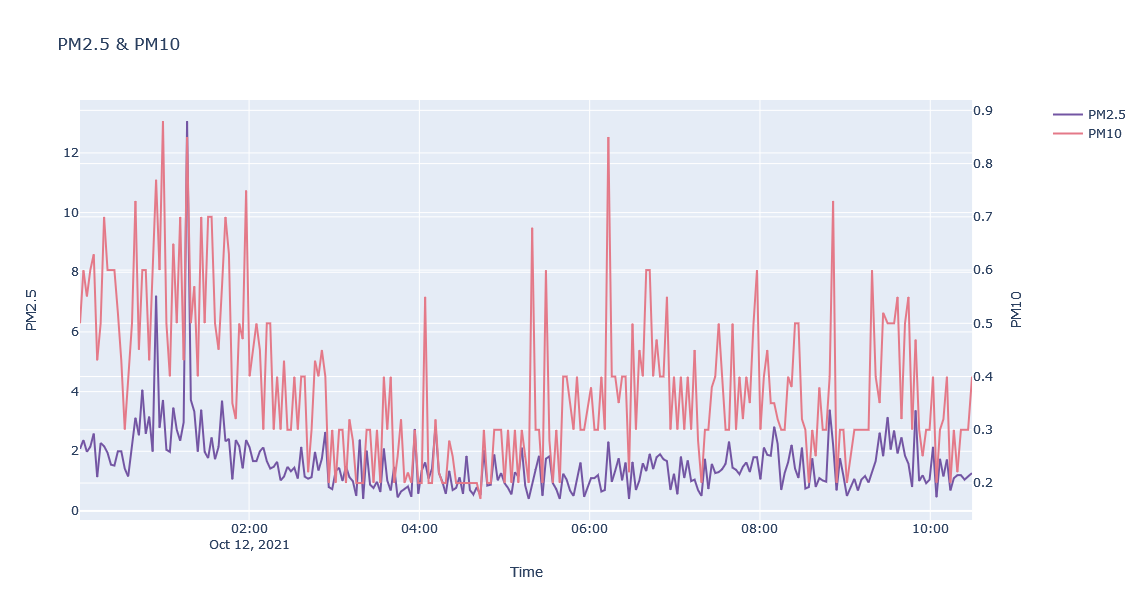

In [245]:
#plotting latest data of one day in plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plotting(df):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(x=df['Time'], y=df['SDS_P1'], name="PM2.5", line=dict(color='#7355A3')),
        secondary_y=False,

    )

    fig.add_trace(
        go.Scatter(x=df['Time'], y=df['SDS_P2'], name="PM10", line=dict(color='#E47988')),
        secondary_y=True,
    )

    # Add figure title
    fig.update_layout(
        title_text="PM2.5 & PM10",
        height=600
    )

    # Set x-axis title
    fig.update_xaxes(title_text="Time")

    # Set y-axes titles
    fig.update_yaxes(title_text="PM2.5", secondary_y=False)
    fig.update_yaxes(title_text="PM10", secondary_y=True)

    fig.show()
    
plotting(df)

./week removed successfully
100% [..............................................................................] 45106 / 45106

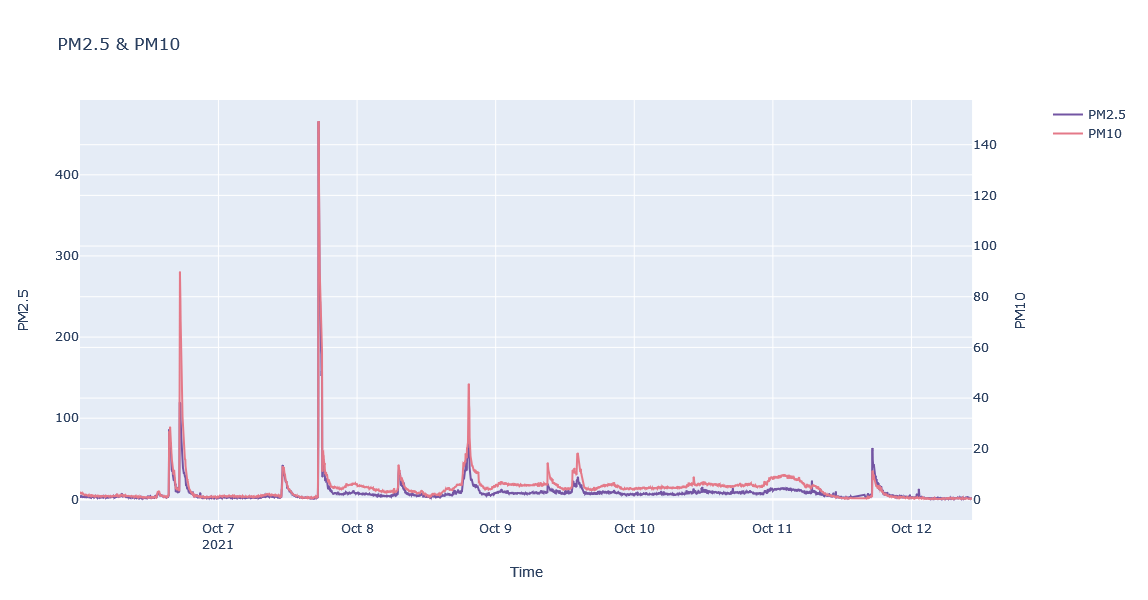

./month removed successfully
100% [..............................................................................] 38248 / 38248

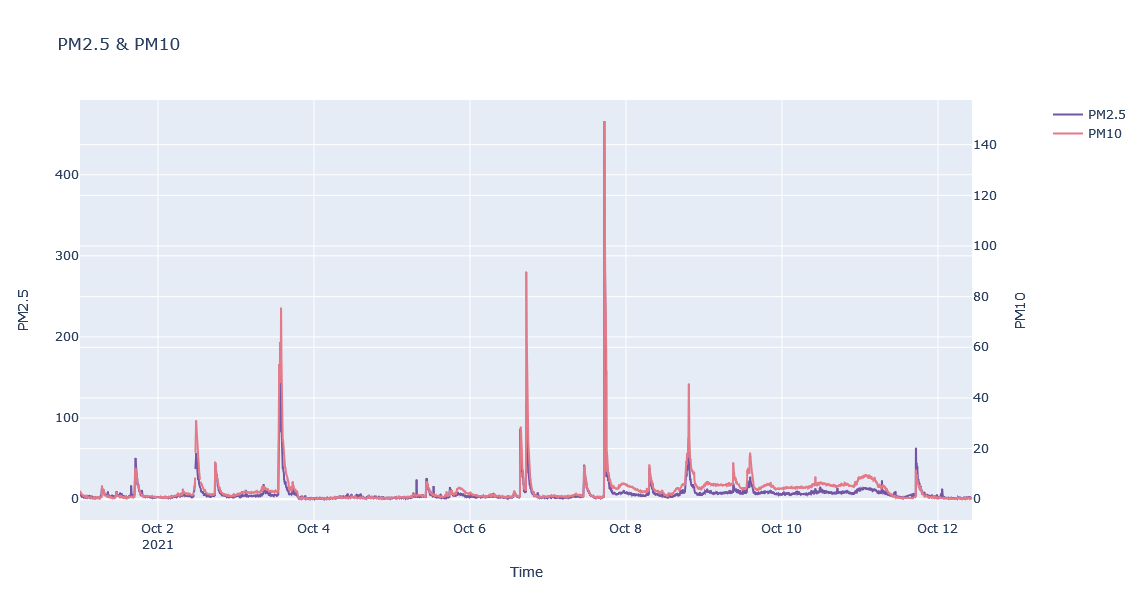

In [246]:
#WEEKLY and MONTHLY datas fetching
#Check if folder is already exists -> if yes then delete it
import shutil
import glob

def checkfolder(folder):
    path = './' + folder
    isdir = os.path.isdir(path)
    if isdir == True:
        shutil.rmtree(path)
        print("% s removed successfully" % path)
    else:
        print("Creating " + folder)

#download weekly datas
def download_datas(folder,timeinterval):
    path = './' + folder + ''
    os.mkdir(folder)
    for date in timeinterval:
        date=str(date)
        link = 'https://api-rrd.madavi.de/data_csv/csv-files/'+ date + '/data-esp8266-12776407-'+ date + '.csv'
        wget.download(link, path)
        
def join_csvfiles(folder):
    path = './' + folder + ''
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df_from_each_file = (pd.read_csv(f, sep=';') for f in all_files)
    df_merged   = pd.concat(df_from_each_file, ignore_index=True)
    df_merged.to_csv("./"+folder+"/merged.csv")

checkfolder("week")      
download_datas("week",week)    
join_csvfiles("week")

df_week = pd.read_csv("./week/merged.csv",sep=",")

#plotting latest data of one week in plotly
df_week['Time'] = df_week['Time'].apply(convert_datetime)
plotting(df_week)

#fetch and plot data of one month
checkfolder("month")
download_datas("month", month)
join_csvfiles("month")
df_month = pd.read_csv("./month/merged.csv",sep=",")
df_month['Time'] = df_month['Time'].apply(convert_datetime)
plotting(df_month)

In [247]:
#find last month and export to string
last_month = int(str(today)[5:7]) #10
last_month = 12 if last_month == 1 else last_month-1
if len(str(last_month)) == 1:
    last_month = "0" + str(last_month) #09

In [249]:
#download data of last month
last_month_link = "https://api-rrd.madavi.de/data_csv/2021/"+last_month+"/data-esp8266-"+sensor_id+"-2021-"+last_month+".zip"
checkfolder(last_month)
path = './'+last_month
os.mkdir(last_month)
wget.download(last_month_link, path)

./09 removed successfully
100% [............................................................................] 308274 / 308274

'./09/data-esp8266-12776407-2021-09.zip'

In [250]:
from zipfile import ZipFile 
dir = os.listdir(path)
file = dir[0]
path = path+"/"+file
# open the zip file in read mode
with ZipFile(path, 'r') as zip: 
    # extract all files to directory
    zip.extractall(last_month)
    
os.remove(path) #delete zip file

In [251]:
join_csvfiles(last_month)

In [252]:
df_last_month = pd.read_csv("./"+last_month+"/merged.csv",sep=",",low_memory=False)
df_last_month.head()

Unnamed: 0                 Time  durP1  ratioP1  P1  durP2  ratioP2  P2  \
0           0  2021/09/01 00:01:29    NaN      NaN NaN    NaN      NaN NaN   
1           1  2021/09/01 00:03:55    NaN      NaN NaN    NaN      NaN NaN   
2           2  2021/09/01 00:06:20    NaN      NaN NaN    NaN      NaN NaN   
3           3  2021/09/01 00:08:49    NaN      NaN NaN    NaN      NaN NaN   
4           4  2021/09/01 00:11:14    NaN      NaN NaN    NaN      NaN NaN   

   SDS_P1  SDS_P2  ...  BMP_pressure  BME280_temperature  BME280_humidity  \
0    6.47    3.00  ...           NaN                 NaN              NaN   
1    6.72    2.78  ...           NaN                 NaN              NaN   
2    6.22    3.17  ...           NaN                 NaN              NaN   
3    7.22    3.15  ...           NaN                 NaN              NaN   
4    7.65    3.15  ...           NaN                 NaN              NaN   

   BME280_pressure  Samples  Min_cycle  Max_cycle  Signal  HPM_P1  HPM_P2  
0              NaN  5037098         28      20025     -58     NaN     NaN  
1              NaN  5036675         28      20380     -58     NaN     NaN  
2              NaN  5036660         28      20087     -59     NaN     NaN  
3              NaN  5036618         28      20045     -59     NaN     NaN  
4              NaN  5035083         28      20029     -59     NaN     NaN  

[5 rows x 25 columns]

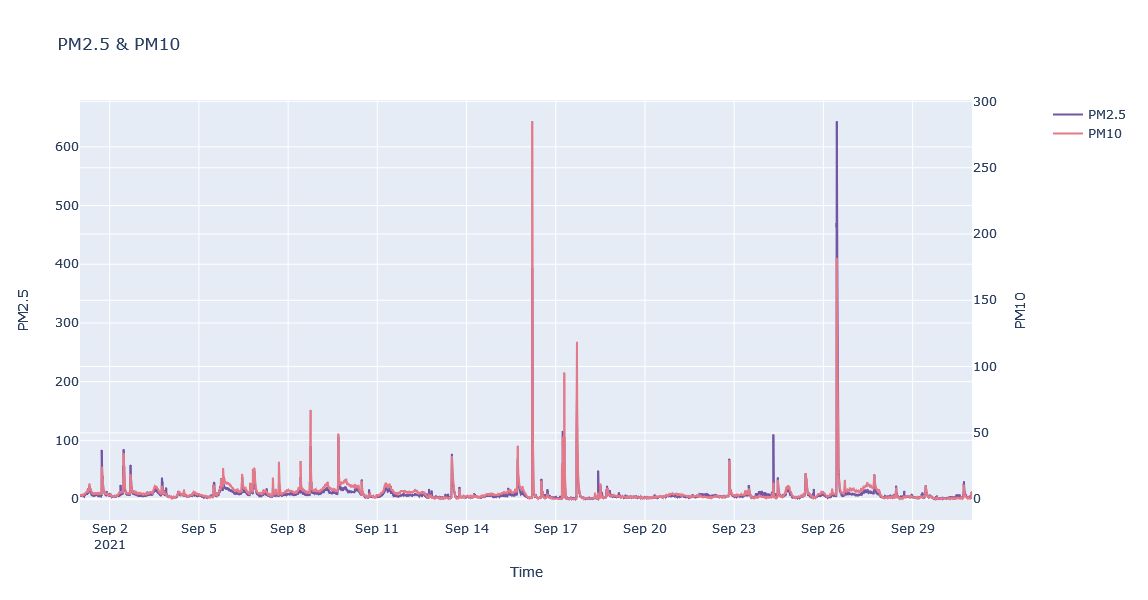

In [253]:
df_last_month['Time'] = pd.to_datetime(df_last_month['Time'], errors='coerce')
plotting(df_last_month)